In [1]:
%autosave 60
%pylab inline

import os
import re
import sys
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

current_directory = os.path.dirname(os.getcwd()) 
data_folder = os.path.normpath(os.path.join(current_directory + "/data"))

Autosaving every 60 seconds
Populating the interactive namespace from numpy and matplotlib


In [95]:
df = pd.read_csv(os.path.join(data_folder + "/main_upd4.csv"), encoding="utf-8", sep=";")
df.date = pd.to_datetime(df.date).dt.date
df = df[df.date < datetime.date(2022, 1, 1)]
df.type = df.type.str.replace("Пресс-релиз", "0").str.replace("Выступление", "1").astype(int)
df.tail()

,date,type,header,text,url,rate_flag,splittext
12639,2021-12-30,0,Прекращена деятельность временной администраци...,Временная администрация Общества с ограниченно...,https://www.cbr.ru/press/pr/?file=30122021_155...,0,NaN
12640,2021-12-30,0,Прекращена деятельность временной администраци...,Банк России 30.12.2021 прекратил деятельность ...,https://www.cbr.ru/press/pr/?file=30122021_170...,0,NaN
12641,2021-12-30,0,Опубликована Программа обследований Банка Росс...,На официальном сайте Банка России размещена Пр...,https://www.cbr.ru/press/pr/?file=30122021_150...,0,NaN
12642,2021-12-30,0,"Вышел очередной номер ""Вестника Банка России""","Вышел ""Вестник Банка России"" № 92 (2332) от 30...",https://www.cbr.ru/press/pr/?file=30122021_140...,0,NaN
12643,2021-12-30,0,Информация о сопоставлении рейтинговых шкал ро...,Банк России публикует таблицу сопоставления ре...,https://www.cbr.ru/press/pr/?file=30122021_101...,0,NaN


# Descriptive stats

In [96]:
df['text_len'] = df.text.str.len()
df.groupby(["type", "rate_flag"])['text_len'].agg(["count","mean",'min', 'max'])

count          mean    min    max
type rate_flag                                   
0    0          12410   1414.795488    131  31075
     1            111   4805.252252    496  10143
1    0             82  18790.317073    192  43320
     1             41  30366.341463  13700  38361

In [97]:
df.sort_values(by='text_len').head(10).header

11515         О размещении купонных облигаций Банка России
9492     О внесении сведений в реестр ответственных акт...
11080                                О кадровых изменениях
11328                                О кадровых изменениях
11403         О размещении купонных облигаций Банка России
12386    Информация о завершении размещения купонных об...
11467         О размещении купонных облигаций Банка России
11434         О размещении купонных облигаций Банка России
12342    О завершении размещения купонных облигаций Бан...
12491    Информация о завершении размещения купонных об...
Name: header, dtype: object

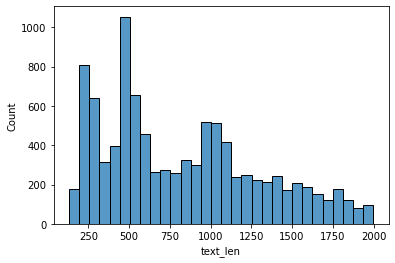

In [98]:
df_temp = df[(df.type == 0) & (df.rate_flag == 0) & (df.text_len < 2000)]
sns.histplot(df_temp.text_len)

# Simple methods

## Dictionary-based (HOLD)

## Dostoevsky
https://pypi.org/project/dostoevsky/

In [6]:
# pip install dostoevsky

In [100]:
import dostoevsky
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

def metrics_vec(results):
    metrics = [[i['negative'], i['positive'], i['neutral']] for i in results]
    metrics = np.array(metrics)
    metrics_sum = metrics.sum(axis=1)
    return (metrics / metrics_sum[:, np.newaxis]).T

In [101]:
%%time
messages = df.text.tolist()

allresults = model.predict(messages, k=5)

Wall time: 39.9 s


In [102]:
metrics = metrics_vec(allresults)
df['negative'] = metrics[0]
df['positive'] = metrics[1]
df['tone'] = (df['negative'] - df['positive'])

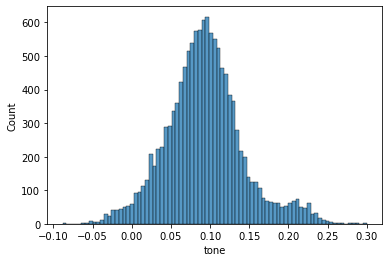

In [103]:
sns.histplot(df.tone)
plt.show()

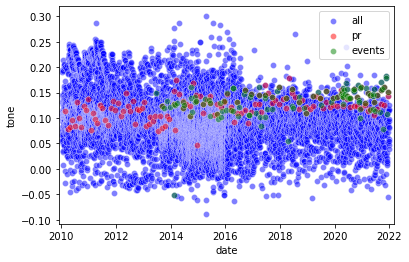

In [104]:
# overall
sns.scatterplot(x = df.date, y = df.tone, alpha=0.5, color='b', label='all')
sns.scatterplot(x = df[df.rate_flag == 1].date, y = df[df.rate_flag == 1].tone, alpha=0.5, color='r', label='pr')
sns.scatterplot(x = df[df.type == 1].date, y = df[df.type == 1].tone, alpha=0.5, color='g', label='events')
plt.xlim((datetime.date(2009, 12, 1), datetime.date(2022, 3, 1)))
plt.legend()
plt.show()

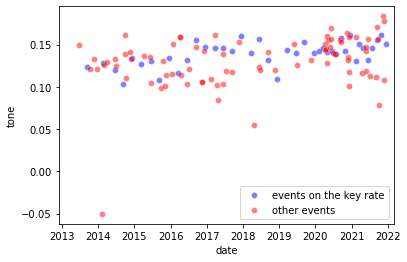

In [105]:
# выступления
df_temp = df[(df.type == 1) & (df.rate_flag == 1)]
sns.scatterplot(x = df_temp.date, y  = df_temp.tone, alpha=0.5, color='b', label='events on the key rate')
plt.xlim((datetime.date(2012, 12, 1), datetime.date(2022, 3, 1)))
df_temp = df[(df.type == 1) & (df.rate_flag != 1)]
sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=0.5, color='r', label='other events')
plt.legend()
plt.show()

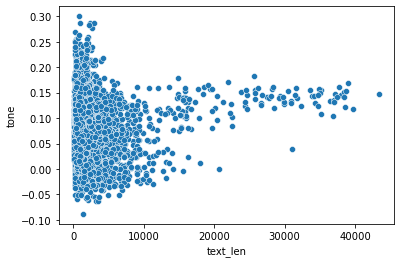

In [106]:
sns.scatterplot(x = df.text_len, y = df.tone)
plt.show()

In [107]:
df.to_csv("main_upd5.csv", encoding="utf-8", sep=";", index=False)

In [28]:
# добавить для splittext

# Продвинутые метрики

# Добавляем рыночные метрики

In [5]:
df = pd.read_csv(os.path.join(data_folder + "/main_upd5.csv"), encoding="utf-8", sep=";")
df.date = pd.to_datetime(df.date).dt.date
df.head()

,date,type,header,text,url,rate_flag,splittext,text_len,negative,positive,tone
0,2010-01-11,0,О результатах мониторинга максимальных процент...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_133902...,0,NaN,801,0.094714,0.013910,0.080804
1,2010-01-11,0,Об условиях проведения Банком России 11.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_104827...,0,NaN,553,0.181789,0.076406,0.105383
2,2010-01-11,0,О проведении ломбардных кредитных аукционов,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_161453...,0,NaN,322,0.149605,0.085060,0.064544
3,2010-01-12,0,Об условиях проведения Банком России 12.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_112503...,0,NaN,553,0.183338,0.077057,0.106281
4,2010-01-12,0,Об итогах проведения ломбардных кредитных аукц...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_181233...,0,NaN,1726,0.250569,0.055870,0.194700


In [6]:
dfm = pd.read_csv(os.path.join(data_folder + "/imoex.csv"))
dfm['TRADEDATE'] = pd.to_datetime(dfm['TRADEDATE'], format="%d.%m.%Y").dt.date
dfm = dfm.sort_values(by='TRADEDATE')

for col in dfm.columns[-5:]:
    dfm[col] = dfm[col].str.replace(",", ".").astype(float)
    
dfm.CLOSE = dfm.CLOSE / dfm.CLOSE[0]

In [7]:
dfm.isna().any()

BOARDID      False
SECID        False
TRADEDATE    False
SHORTNAME    False
NAME         False
CLOSE        False
OPEN         False
HIGH         False
LOW          False
VALUE        False
dtype: bool

In [8]:
(dfm.iloc[:, -5:] == 0).any()

CLOSE    False
OPEN     False
HIGH     False
LOW      False
VALUE     True
dtype: bool

In [9]:
df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
df_temp = pd.merge(df_temp, dfm[['TRADEDATE', "CLOSE"]], how='left', left_on='date', right_on='TRADEDATE')
# df_temp.groupby("date")['url'].count().sort_values()
df_temp.head(3)

,date,type,header,text,url,rate_flag,splittext,text_len,negative,positive,tone,TRADEDATE,CLOSE
0,2013-09-13,1,Информация по итогам брифинга Председателя Бан...,"Добрый день, уважаемые коллеги. Я хочу рассказ...",https://www.cbr.ru/press/event/?id=5196,1,"Добрый день, уважаемые коллеги. Я хочу рассказ...",32388,0.208317,0.084750,0.123568,2013-09-13,0.997204
1,2014-02-14,1,Заявление Председателя Банка России Э.С. Набиу...,Сегодня Совет директоров Банка России принял р...,https://www.cbr.ru/press/event/?id=5200,1,Сегодня Совет директоров Банка России принял р...,29889,0.212981,0.084811,0.128170,2014-02-14,1.035576
2,2014-06-16,1,Заявление Председателя Банка России Э.С. Набиу...,Совет директоров Банка России принял сегодня р...,https://www.cbr.ru/press/event/?id=5204,1,Совет директоров Банка России принял сегодня р...,28498,0.194505,0.074153,0.120352,2014-06-16,1.034019


In [21]:
import statsmodels.formula.api as smf

In [25]:
model = smf.ols('CLOSE ~ tone', data=df_temp).fit()
print(model.summary())

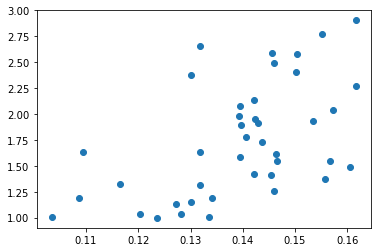

In [204]:
Y = df_temp['CLOSE']
X = df_temp.tone
plt.scatter(X, Y)